# Stock Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [127]:
# download the data
#!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

In [128]:
#!ls .

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [130]:
# Importing the training set
dataset = data = pd.read_csv('https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='AAL'].close.values

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [131]:
dataset_cl.shape

(1259,)

In [132]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [133]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)


In [134]:
# every 7 days for one group 
X

array([[0.03806381, 0.03168317, 0.02750275, ..., 0.02134213, 0.03256326,
        0.02728273],
       [0.03168317, 0.02750275, 0.03608361, ..., 0.03256326, 0.02728273,
        0.00682068],
       [0.02750275, 0.03608361, 0.02134213, ..., 0.02728273, 0.00682068,
        0.00770077],
       ...,
       [0.9190319 , 0.88074807, 0.88118812, ..., 0.87062706, 0.90869087,
        0.8990099 ],
       [0.88074807, 0.88118812, 0.87260726, ..., 0.90869087, 0.8990099 ,
        0.85984598],
       [0.88118812, 0.87260726, 0.87062706, ..., 0.8990099 , 0.85984598,
        0.80836084]])

In [135]:
# every 8th days for prediction
y

array([0.00682068, 0.00770077, 0.01210121, ..., 0.85984598, 0.80836084,
       0.83960396])

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [136]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):] # take 80% as train, 20% as test
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


In [137]:
# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

## Step 4:  Build and run an LSTM regression model

In [138]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state): #forward method is that you can invoke it by calling the model
        r_out, hidden_state = self.rnn(x, h_state)
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [139]:
# Globals
INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128

# Hyper parameters
learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
#rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [140]:
history = []
X_test_cuda = torch.tensor(X_test).float() #.cuda()
y_test_cuda = torch.tensor(y_test).float() #.cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float() #.cuda()   #torch.Size([1000, 1, 7])
labels_cuda = torch.tensor(y_train).float() #.cuda()   #torch.Size([1000])

for epoch in range(num_epochs):
    
    
    # model.train() tells your model that you are training the model. 
    # This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation. 
    # For instance, in training mode, BatchNorm updates a moving average on each new batch; whereas, for evaluation mode, these updates are frozen.
    rnn.train() 

    #defualt hidden_state is none
    output, _ = rnn(inputs_cuda, hidden_state) 

    #.view(-1) flatten the tensor so it can compare with labels_cuda's shape which is [1000]
    #output shape is torch.Size([1000, 1, 1]) so use [:,0,:]
    loss = criterion(output[:,0,:].view(-1), labels_cuda) 

    optimiser.zero_grad()               # set gradients back to 0 otherwise gradients added up
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters

    #print eval info for visualization 
    if epoch % 20 == 0:
        #model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. 
        #For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you.
        rnn.eval() 
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.4271516799926758, eval loss 0.7375483512878418
epoch 1, loss 0.39848241209983826
epoch 2, loss 0.3708029091358185
epoch 3, loss 0.34328246116638184
epoch 4, loss 0.31431615352630615
epoch 5, loss 0.2836788296699524
epoch 6, loss 0.2502467632293701
epoch 7, loss 0.21287551522254944
epoch 8, loss 0.17253082990646362
epoch 9, loss 0.1267899125814438
epoch 10, loss 0.08028991520404816
epoch 11, loss 0.039797015488147736
epoch 12, loss 0.02760065160691738
epoch 13, loss 0.06704956293106079
epoch 14, loss 0.08749760687351227
epoch 15, loss 0.07045198976993561
epoch 16, loss 0.046278711408376694
epoch 17, loss 0.031445082277059555
epoch 18, loss 0.026416584849357605
epoch 19, loss 0.028690742328763008
epoch 20, loss 0.033586569130420685, eval loss 0.09381791204214096
epoch 21, loss 0.03805529698729515
epoch 22, loss 0.0408029668033123
epoch 23, loss 0.04198567569255829
epoch 24, loss 0.04076937958598137
epoch 25, loss 0.0379573293030262
epoch 26, loss 0.03437362611293793
epoch

In [141]:
print(rnn.out.weight)
print(rnn.out.weight.shape)

Parameter containing:
tensor([[ 0.0534, -0.0704, -0.1246, -0.0926,  0.0375,  0.1107, -0.0648, -0.0087,
         -0.0878,  0.0311,  0.1045, -0.1008, -0.0888,  0.1174, -0.1263, -0.0899,
         -0.0737,  0.0170,  0.1078, -0.0658,  0.0153,  0.0030,  0.0948,  0.0682,
         -0.0939,  0.0321,  0.0906, -0.0542, -0.0745, -0.0113, -0.0427, -0.0163,
          0.1071, -0.0170, -0.0105, -0.0360,  0.0389, -0.0455,  0.0249,  0.0843,
          0.0257,  0.0853, -0.0323, -0.1042, -0.0192, -0.0041,  0.0409, -0.0205,
         -0.1231, -0.0329, -0.0911,  0.1076,  0.0537,  0.0863, -0.0248, -0.0647,
         -0.0221, -0.0394,  0.0847, -0.1027, -0.0579,  0.0455, -0.0653,  0.0102]],
       requires_grad=True)
torch.Size([1, 64])


In [142]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.0358, -0.0176,  0.1273,  ..., -0.0766, -0.0594, -0.0849],
        [-0.0555, -0.1029,  0.0046,  ..., -0.0611,  0.0259,  0.0908],
        [-0.0247,  0.0835,  0.0439,  ...,  0.0560,  0.1324, -0.0815],
        ...,
        [ 0.1058,  0.1073, -0.0948,  ..., -0.0075,  0.1164,  0.1042],
        [-0.1169, -0.1301, -0.0740,  ...,  0.0593, -0.1080, -0.0093],
        [-0.0746,  0.1325,  0.0080,  ...,  0.0964,  0.0311,  0.0873]])
tensor([[ 1.3168e-01,  3.8938e-02,  6.6755e-02,  ..., -1.1841e-01,
          3.1625e-05,  8.2589e-03],
        [ 1.0775e-01, -5.9327e-02, -6.4406e-02,  ..., -1.0605e-01,
          9.3259e-02,  1.6778e-02],
        [ 7.4933e-02,  1.2386e-01,  2.8556e-02,  ..., -1.2762e-01,
         -6.8820e-02,  8.7425e-02],
        ...,
        [-3.3941e-02,  7.6576e-02,  4.4654e-02,  ..., -2.6345e-02,
          8.2693e-02, -6.5332e-02],
        [-1.0608e-01,  8.9755e-02,  6.8586e-02,  ...,  2.6473e-02,
         -8.1559e-02,  6.4020e-02],
        [ 9.8709e-02, -8.2312e-02,  6.

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

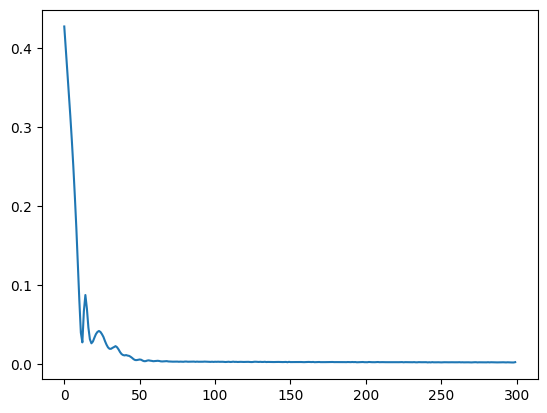

In [143]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [144]:
X_test[0]

array([[0.70143014, 0.68712871, 0.68272827, 0.68184818, 0.6860286 ,
        0.71023102, 0.70737074]])

In [145]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [146]:
test_predict_cpu.shape

(251, 1, 1)

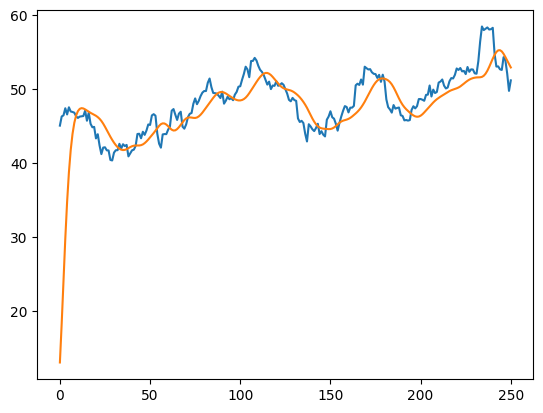

In [147]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

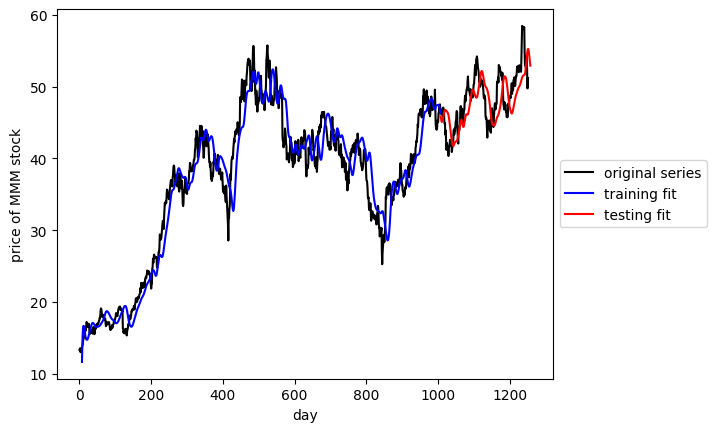

In [148]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
